- With stratified k fold
- img_aug image augmentation
- tweak adam learning rate for second model
- remove image where mask have only 1 to 10 white pixels

# Import Dependencies

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.10.1


# Pre-process Data

In [3]:
DATA_DIR = 'data/salt/'

In [4]:
cv_total = 4
cv_index = 1  # 0,1,2,3

In [5]:
version = 2
basic_name = f'unet_v2_{version}'
save_model_name = basic_name + 'A_cv' + str(cv_index) + '.model'
save_model_nameB = basic_name + 'B_cv' + str(cv_index) + '.model'
submission_file = basic_name + '_cv' + str(cv_index) + '.csv'

print(save_model_name)
print(save_model_nameB)
print(submission_file)

unet_v2_2A_cv1.model
unet_v2_2B_cv1.model
unet_v2_2_cv1.csv


In [6]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [7]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(f"{DATA_DIR}train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(f"{DATA_DIR}depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [8]:
train_df["images"] = [np.array(load_img(f"{DATA_DIR}train/images/{idx}.png", color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [9]:
train_df["masks"] = [np.array(load_img(f"{DATA_DIR}train/masks/{idx}.png", color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [10]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

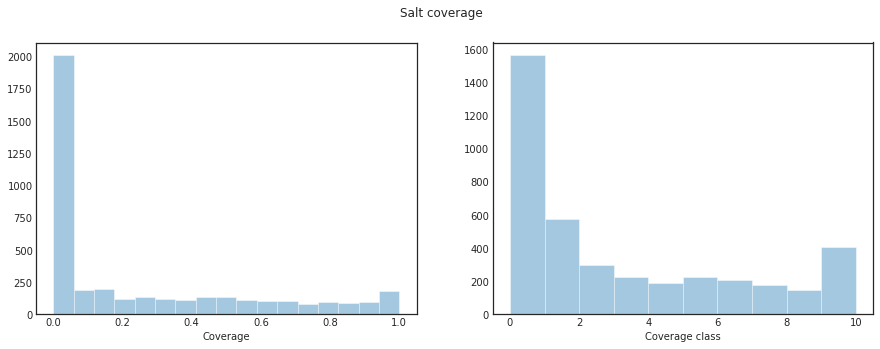

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 1.0, 'Depth distribution')

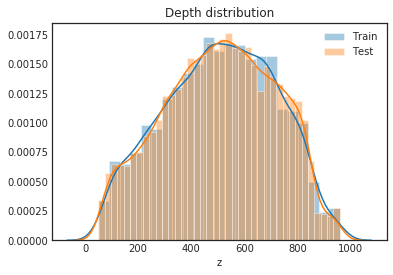

In [12]:
# Plotting the depth distributions

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Split Data

In [13]:
# # Create train/validation split stratified by salt coverage
# ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
# train_test_split(train_df.index.values, 
#                  np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
#                  np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
#                  train_df.coverage.values, 
#                  train_df.z.values, 
#                  test_size=0.2, stratify=train_df.coverage_class, random_state=555)

In [14]:
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=555, shuffle=True)

for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape, evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(2996,) (1004,)
(2999,) (1001,)
(3002,) (998,)
(3003,) (997,)


In [15]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

In [16]:
x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)    

In [17]:
x_train[5,5,5]

array([0.6])

In [18]:
len(x_train), len(y_train)

(2999, 2999)

In [19]:
# boolean mask for mask with either all black pixel or at least 20 pixels
thres = 10
y_mask = np.squeeze((y_train.sum(axis=1).sum(axis=1)>=thres) | (y_train.sum(axis=1).sum(axis=1)==0))

In [20]:
# sample to remove
len(y_train)-y_mask.sum()

34

In [21]:
x_train = x_train[y_mask]
y_train = y_train[y_mask]

In [22]:
len(x_train), len(y_train)

(2965, 2965)

In [23]:
x_train_orig_len = len(x_train)
x_train_orig_len

2965

In [24]:
# only remove train, do not remove validation
len(x_valid), len(y_valid)

(1001, 1001)

# Data augmentation

In [25]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[0].grid(False)
    axarr[1].grid(False)
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

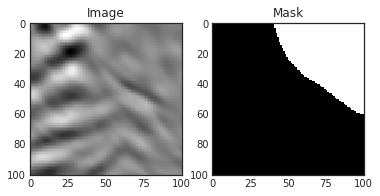

In [26]:
i = 21
plot2x2Array(x_train[i,:,:,0], y_train[i,:,:,0])

In [27]:
from imgaug import augmenters as iaa
import imgaug as ia

sometimes = lambda aug: iaa.Sometimes(0.9, aug)

In [28]:
affine_seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode= 'symmetric',
            pad_cval=(0, 1),
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, # translate by -20 to +20 percent (per axis)
            shear=(-10, 10), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 1), # if mode is constant, use a cval between 0 and 255
            mode='symmetric',
        )),
    
], random_order=True)

In [29]:
seq_det = affine_seq.to_deterministic()
aug_img = seq_det.augment_image(x_train[i,:,:])
aug_mask = seq_det.augment_image(y_train[i,:,:])

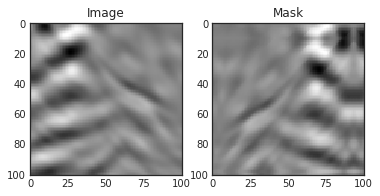

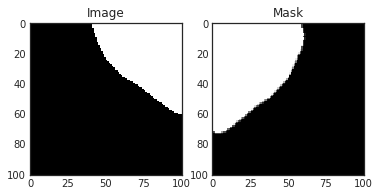

In [30]:
plot2x2Array(x_train[i,:,:,0], aug_img[:,:,0])
plot2x2Array(y_train[i,:,:,0], aug_mask[:,:,0])

In [31]:
aug_mask = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

In [32]:
np.unique(y_train[i,:,:,0])

array([0., 1.])

In [33]:
np.unique(aug_mask)

array([0, 1])

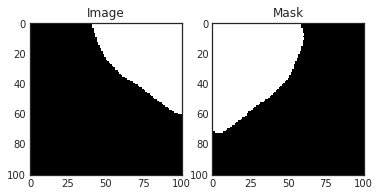

In [34]:
plot2x2Array(y_train[i,:,:,0], aug_mask)

(101, 101, 1) (101, 101, 1)
(101, 101, 1) (101, 101, 1)


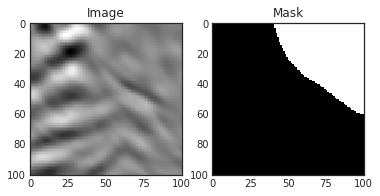

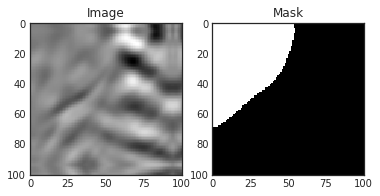

In [35]:
x = x_train[21]
y = y_train[21]
print((x.shape),(y.shape))

seq_det = affine_seq.to_deterministic()
aug_img = seq_det.augment_image(x)
aug_mask = seq_det.augment_image(y)
aug_mask[:,:,0] = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

print((aug_img.shape),(aug_mask.shape))
plot2x2Array(x[:,:,0], y[:,:,0])

plot2x2Array(aug_img[:,:,0], aug_mask[:,:,0])

In [36]:
x_aug_list=[]
y_aug_list=[]

for x,y in tqdm_notebook(zip(x_train, y_train)):
    seq_det = affine_seq.to_deterministic()
    
    aug_img = seq_det.augment_image(x)
    aug_mask = seq_det.augment_image(y)
    aug_mask[:,:,0] = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

    x_aug_list.append(aug_img)
    y_aug_list.append(aug_mask)

In [37]:
# x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
# y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [38]:
x_aug = np.array(x_aug_list)
y_aug = np.array(y_aug_list)

In [39]:
x_aug.shape

(2965, 101, 101, 1)

In [40]:
x_train = np.append(x_train, x_aug, axis=0)
y_train = np.append(y_train, y_aug, axis=0)

In [41]:
print(x_train.shape)
print(y_valid.shape)

(5930, 101, 101, 1)
(1001, 101, 101, 1)


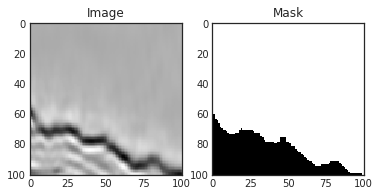

In [42]:
i = 188
plot2x2Array(x_train[i,:,:,0], y_train[i,:,:,0])

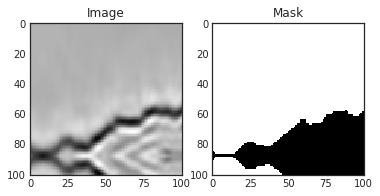

In [43]:
plot2x2Array(x_train[i+x_train_orig_len,:,:,0], y_train[i+x_train_orig_len,:,:,0])

# Model Definitions

In [44]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [45]:
# Build Model
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# Metric Loss

In [46]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [47]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

# Build Model

In [48]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr=0.0005)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

# model1.summary()

In [49]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=22, verbose=1)

model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric', mode='max', 
                                   save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=6,
                              min_lr=0.0001, verbose=1)

epochs = 250
batch_size = 128

In [50]:
%%time
history = model1.fit(x_train, y_train,
                     validation_data = [x_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 1)

Train on 5930 samples, validate on 1001 samples
Epoch 1/250
5930/5930 [==============================] - 77s 13ms/step - loss: 0.8891 - my_iou_metric: 0.1261 - val_loss: 0.7025 - val_my_iou_metric: 0.1040

Epoch 00001: val_my_iou_metric improved from -inf to 0.10400, saving model to unet_v2_2A_cv1.model
Epoch 2/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.6555 - my_iou_metric: 0.0844 - val_loss: 0.9031 - val_my_iou_metric: 0.1176

Epoch 00002: val_my_iou_metric improved from 0.10400 to 0.11758, saving model to unet_v2_2A_cv1.model
Epoch 3/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.5946 - my_iou_metric: 0.1256 - val_loss: 0.6291 - val_my_iou_metric: 0.1077

Epoch 00003: val_my_iou_metric did not improve from 0.11758
Epoch 4/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.5342 - my_iou_metric: 0.1912 - val_loss: 0.5781 - val_my_iou_metric: 0.2718

Epoch 00004: val_my_iou_metric improved from 0.11758 to 0.2

Epoch 35/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.1484 - my_iou_metric: 0.6999 - val_loss: 0.2026 - val_my_iou_metric: 0.6869

Epoch 00035: val_my_iou_metric did not improve from 0.68961
Epoch 36/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.1461 - my_iou_metric: 0.7086 - val_loss: 0.1960 - val_my_iou_metric: 0.6705

Epoch 00036: val_my_iou_metric did not improve from 0.68961
Epoch 37/250
5930/5930 [==============================] - 61s 10ms/step - loss: 0.1444 - my_iou_metric: 0.7144 - val_loss: 0.2224 - val_my_iou_metric: 0.6353

Epoch 00037: val_my_iou_metric did not improve from 0.68961
Epoch 38/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.1422 - my_iou_metric: 0.7080 - val_loss: 0.2035 - val_my_iou_metric: 0.6670

Epoch 00038: val_my_iou_metric did not improve from 0.68961
Epoch 39/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.1372 - my_iou_metric: 0.7197 - val_loss: 0

5930/5930 [==============================] - 60s 10ms/step - loss: 0.0803 - my_iou_metric: 0.7814 - val_loss: 0.2044 - val_my_iou_metric: 0.7410

Epoch 00070: val_my_iou_metric improved from 0.73946 to 0.74096, saving model to unet_v2_2A_cv1.model
Epoch 71/250
5930/5930 [==============================] - 61s 10ms/step - loss: 0.0783 - my_iou_metric: 0.7855 - val_loss: 0.2037 - val_my_iou_metric: 0.7391

Epoch 00071: val_my_iou_metric did not improve from 0.74096
Epoch 72/250
5930/5930 [==============================] - 61s 10ms/step - loss: 0.0798 - my_iou_metric: 0.7767 - val_loss: 0.2074 - val_my_iou_metric: 0.7338

Epoch 00072: val_my_iou_metric did not improve from 0.74096
Epoch 73/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.0802 - my_iou_metric: 0.7823 - val_loss: 0.2070 - val_my_iou_metric: 0.7374

Epoch 00073: val_my_iou_metric did not improve from 0.74096
Epoch 74/250
5930/5930 [==============================] - 61s 10ms/step - loss: 0.0781 - my_iou

5930/5930 [==============================] - 60s 10ms/step - loss: 0.0637 - my_iou_metric: 0.8003 - val_loss: 0.2352 - val_my_iou_metric: 0.7287

Epoch 00107: val_my_iou_metric did not improve from 0.74366
Epoch 108/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.0628 - my_iou_metric: 0.8013 - val_loss: 0.2197 - val_my_iou_metric: 0.7466

Epoch 00108: val_my_iou_metric improved from 0.74366 to 0.74655, saving model to unet_v2_2A_cv1.model
Epoch 109/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.0628 - my_iou_metric: 0.8019 - val_loss: 0.2262 - val_my_iou_metric: 0.7384

Epoch 00109: val_my_iou_metric did not improve from 0.74655
Epoch 110/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.0626 - my_iou_metric: 0.8019 - val_loss: 0.2266 - val_my_iou_metric: 0.7366

Epoch 00110: val_my_iou_metric did not improve from 0.74655
Epoch 111/250
5930/5930 [==============================] - 60s 10ms/step - loss: 0.0631 - my

# Remove activation layer and use lovasz loss

In [51]:
model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})

input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.0001)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

# model.summary()

In [52]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)
epochs = 250
batch_size = 128

In [53]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 5930 samples, validate on 1001 samples
Epoch 1/250
 - 177s - loss: -1.9656e-01 - my_iou_metric_2: 0.8185 - val_loss: 0.2624 - val_my_iou_metric_2: 0.7500

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.75005, saving model to unet_v2_2B_cv1.model
Epoch 2/250
 - 161s - loss: -2.3915e-01 - my_iou_metric_2: 0.8218 - val_loss: 0.2218 - val_my_iou_metric_2: 0.7567

Epoch 00002: val_my_iou_metric_2 improved from 0.75005 to 0.75674, saving model to unet_v2_2B_cv1.model
Epoch 3/250
 - 161s - loss: -2.6209e-01 - my_iou_metric_2: 0.8235 - val_loss: 0.2277 - val_my_iou_metric_2: 0.7521

Epoch 00003: val_my_iou_metric_2 did not improve from 0.75674
Epoch 4/250
 - 161s - loss: -2.5864e-01 - my_iou_metric_2: 0.8229 - val_loss: 0.2279 - val_my_iou_metric_2: 0.7486

Epoch 00004: val_my_iou_metric_2 did not improve from 0.75674
Epoch 5/250
 - 161s - loss: -2.7516e-01 - my_iou_metric_2: 0.8258 - val_loss: 0.1962 - val_my_iou_metric_2: 0.7575

Epoch 00005: val_my_iou_metric_2 improved f

# Plot result

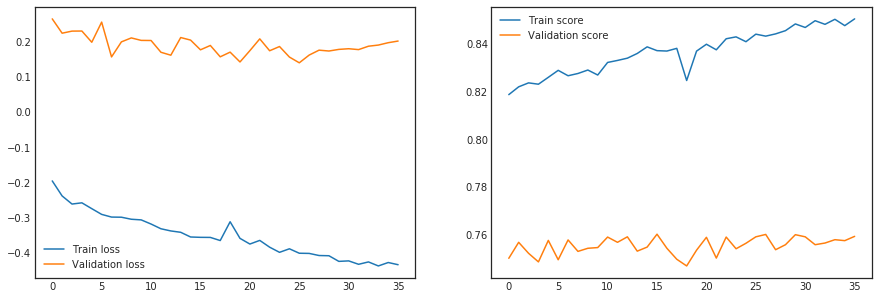

In [54]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [55]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [56]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [57]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [58]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [59]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.75694306 0.75724276 0.75774226 0.76033966 0.76063936 0.76053946
 0.76143856 0.76183816 0.76243756 0.76213786 0.76253746 0.76333666
 0.76233766 0.76403596 0.76463536 0.76383616 0.76323676 0.76283716
 0.76393606 0.76373626 0.76273726 0.76383616 0.76333666 0.76263736
 0.76183816 0.76163836 0.76103896 0.76023976 0.76013986 0.75904096
 0.75814186]


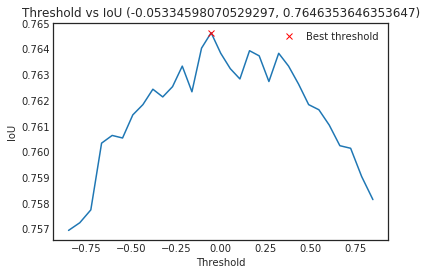

In [60]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [61]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [62]:
x_test = np.array([(np.array(load_img(f"{DATA_DIR}test/images/{idx}.png", grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

SyntaxError: f-string: empty expression not allowed (<ipython-input-62-47533dc91260>, line 1)

In [ ]:
preds_test = predict_result(model,x_test,img_size_target)

In [ ]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")